# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 1 - Smoothers and Generalized Additive Models



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

In [131]:
# chris had s=1 if don't average daily price. range from 0 to 1000 in log increments



### Homework 1 is due February 6th

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder

# Seaborn visualization library
import seaborn as sns


<hr style="height:2pt">

### Problem 1 - Modeling Seasonality of Airbnb Prices
In this problem, the task is to build a regression model to predict the price of an Airbnb rental for a given date. The data are provided in `calendar_train.csv` and `calendar_test.csv`, which contain availability and price data for a sample of Airbnb units in the Boston area from 2017 to 2018, about 4 observations per day in each set.

Start by loading the data using pandas.  
*Hint*: You likely want to have pandas parse the `date` column as a datetime object via the `parse_dates` argument of `pd.read_csv`

In [3]:
# load data and parse date column into datetime object

calendar_train = pd.read_csv('data/calendar_train.csv', parse_dates = ['date'])
calendar_test = pd.read_csv('data/calendar_test.csv', parse_dates = ['date'])


In [4]:
# check that calendar_train has price and date info when available
print('Head of calendar_train:\n', calendar_train.head(), '\n\n')
print('Tail of calendar_train:\n', calendar_train.tail(), '\n\n')
print('Describe summary of calendar_train:\n', calendar_train.describe(), '\n\n')
print('Check that prices exist when available for calendar_train:\n', calendar_train[calendar_train['available']=='t']['price'], '\n\n')


Head of calendar_train:
    listing_id       date available  price
0    20872145 2018-09-21         f    NaN
1    20872145 2018-09-19         f    NaN
2    20872145 2018-09-18         f    NaN
3    20872145 2018-09-17         f    NaN
4    20872145 2018-09-16         f    NaN 


Tail of calendar_train:
         listing_id       date available  price
733998     4759640 2017-12-21         f    NaN
733999     4759640 2017-12-20         f    NaN
734000     4759640 2017-12-19         f    NaN
734001     4759640 2017-12-18         f    NaN
734002     4759640 2017-12-15         f    NaN 


Describe summary of calendar_train:
          listing_id          price
count  7.340030e+05  309288.000000
mean   1.253864e+07     238.780612
std    6.334971e+06     188.527983
min    3.781000e+03      15.000000
25%    7.281884e+06     115.000000
50%    1.390864e+07     190.000000
75%    1.835457e+07     299.000000
max    2.122836e+07    5993.000000 


Check that prices exist when available for calendar_tra

In [5]:
# check that calendar_test has price and date info when available
print('Head of calendar_test:\n', calendar_test.head(), '\n\n')
print('Tail of calendar_test:\n', calendar_test.tail(), '\n\n')
print('Describe summary of calendar_test:\n', calendar_test.describe(), '\n\n')
print('Check that prices exist when available for calendar_test:\n', calendar_test[calendar_test['available']=='t']['price'], '\n\n')


Head of calendar_test:
    listing_id       date available  price
0    21205442 2018-09-28         t  138.0
1     5166870 2018-08-11         t  210.0
2     9698823 2017-10-17         f    NaN
3    18894466 2018-02-21         f    NaN
4     6765855 2018-09-22         f    NaN 


Tail of calendar_test:
         listing_id       date available  price
314567     2843445 2018-05-11         t   85.0
314568    17591837 2017-12-10         t  199.0
314569    19177794 2018-06-17         f    NaN
314570     5075267 2017-12-30         t  188.0
314571    12023024 2017-10-30         t   40.0 


Describe summary of calendar_test:
          listing_id          price
count  3.145720e+05  133100.000000
mean   1.253792e+07     239.744733
std    6.333996e+06     192.059271
min    3.781000e+03      15.000000
25%    7.281884e+06     115.000000
50%    1.390803e+07     190.000000
75%    1.835689e+07     300.000000
max    2.122836e+07   10000.000000 


Check that prices exist when available for calendar_test:


### Exploratory Analysis

Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends you notice and explain whether or not they make sense.

In [6]:
# extract year, month, day from the datetime objects in the 'date' column
calendar_train['year'] = calendar_train['date'].map(lambda x: x.year)
calendar_train['month'] = calendar_train['date'].map(lambda x: x.month_name())
calendar_train['day of the month'] = calendar_train['date'].map(lambda x: x.day)
calendar_train['day of the week'] = calendar_train['date'].map(lambda x: x.day_name())


calendar_train.head()


,listing_id,date,available,price,year,month,day of the month,day of the week
0,20872145,2018-09-21,f,NaN,2018,September,21,Friday
1,20872145,2018-09-19,f,NaN,2018,September,19,Wednesday
2,20872145,2018-09-18,f,NaN,2018,September,18,Tuesday
3,20872145,2018-09-17,f,NaN,2018,September,17,Monday
4,20872145,2018-09-16,f,NaN,2018,September,16,Sunday


In [7]:
# calculate average price by month
print('Mean price by month:\n\n', calendar_train.groupby(['month']).mean()['price'], '\n\n')

# calculate average price by day of the week
print('Mean price by day of the week:\n\n', calendar_train.groupby(['day of the week']).mean()['price'])


Mean price by month:

 month
April        278.442433
August       272.628181
December     190.547291
February     190.617247
January      185.940598
July         281.397202
June         276.534729
March        220.600371
May          288.174429
November     222.407229
October      271.807400
September    263.820183
Name: price, dtype: float64 


Mean price by day of the week:

 day of the week
Friday       247.686228
Monday       235.088040
Saturday     249.484869
Sunday       237.755570
Thursday     237.950429
Tuesday      233.591537
Wednesday    230.638254
Name: price, dtype: float64


Text(0.5, 0, 'Day of the week')

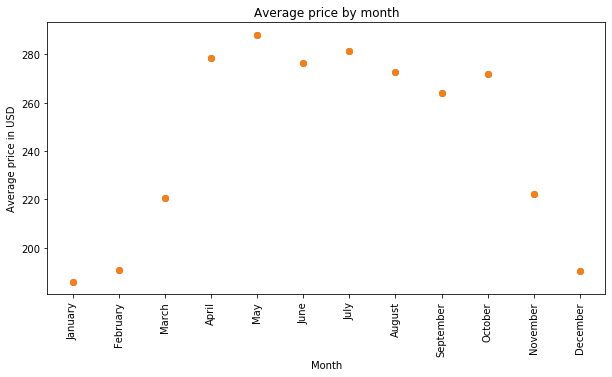

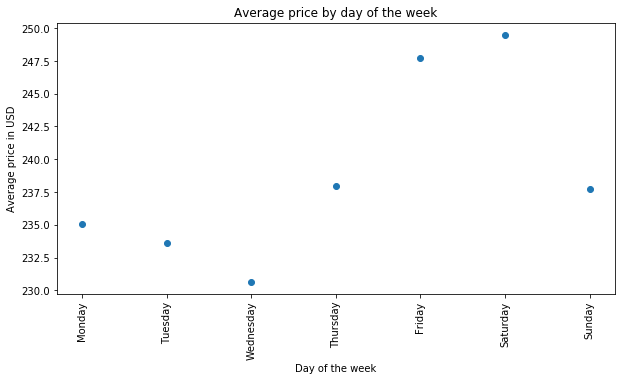

In [8]:
# plot average price by month


plt.rcParams["figure.figsize"] = [10,5]
fig, ax1 = plt.subplots(1,1)
# sort data on x axis
month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
plt.plot(pd.DataFrame(calendar_train.groupby(['month']).mean()).loc[month_order]['price'], marker = 'o', linewidth = 0)
plt.plot(calendar_train.groupby(['month']).mean()['price'], marker = 'o', linewidth = 0)
plt.xticks(rotation='vertical')
ax1.set_title("Average price by month")
ax1.set_ylabel("Average price in USD")
ax1.set_xlabel("Month")

# plot average price by day of the week

fig2, ax2 = plt.subplots(1,1)
# sort data on x axis
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.plot(pd.DataFrame(calendar_train.groupby(['day of the week']).mean()).loc[day_order]['price'], marker = 'o', linewidth = 0)
plt.xticks(rotation='vertical')
ax2.set_title("Average price by day of the week")
ax2.set_ylabel("Average price in USD")
ax2.set_xlabel("Day of the week")



I notice that the average price by month is generally low in winter months (December, January, and February), rises through the spring (March, April, and May), and remains high during the summer (June, July, and August) although some decline in price is observed from May to June and July to August. In the fall (September, October, and November), the average price transitions from moderately high (approx 265 USD) to lower (approx 220 USD). The overall trend is that as the weather gets warmer, the average price increases and as the weather gets cooler, the average price decreases. This makes sense because during the summer when people more frequently are on vacation, AirBnB rentals would be desirable and therefore prices would rise.

From the plot of average price vs. day of the week, we can see that the price is high on Friday and Saturday nights, moderate on Thursday and Sunday nights, and low for Monday through Wednesday nights. This trend indicates that the price for the weekend nights is higher than for weekdays in general. This makes sense because people have time on the weekends away from work to travel and therefore AirBnB rentals would be desirable so prices would rise. 

### Explore different regression models

Fit a regression model that uses the date as a predictor and predicts the price of an Airbnb rental on that date. In this section, you should ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method.

*Hint*: You may want to convert the `date` column into a numerical variable by taking the difference in days between each date and the earliest date in the column.

1. Fit simple polynomial models of degree 2, 3, 5, and 8 to the training data. Provide train and test R^2 scores and provide plot(s) of a) the daily averages and b) each model's predictions.

2. You should see that the degree 8 polynomial's predictions are awful- either nonsensically near zero [or far too large] at many input values. This isn't just simple overfitting. What is going wrong in this model, and how might it be addressed?

3. Fit a Smoothing spline model in `pygam` with the smoothness parameter chosen by cross-validation on the training set. Provide the train and test scores of the best-performing model, and plot its predictions. Also plot the predictions of models with more and less smoothing. When plotting the smooths, show a scatterplot of the daily averages on the same axes, for context.

4. Of the models, which performs the best? What is the effect of the tuning parameters (degree and smoothness penalty)?

In [23]:
# create numerical date column for train set
#calendar_train['numerical_date'] = calendar_train['date'].map(lambda x: (x - calendar_train['date'].min()).days)
#calendar_train.head()

In [56]:
calendar_train_available = calendar_train[calendar_train['available']=='t']
calendar_test_available = calendar_test[calendar_test['available']=='t']

In [57]:
calendar_train_available['numerical_date'] = (calendar_train_available['date'] - calendar_train_available['date'].min())
calendar_test_available['numerical_date'] = (calendar_test_available['date'] - calendar_test_available['date'].min())

//anaconda3/envs/cs109b/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
//anaconda3/envs/cs109b/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [58]:
calendar_train_available.head()

,listing_id,date,available,price,year,month,day of the month,day of the week,numerical_date,numerical_date2
123,20872145,2018-04-02,t,62.0,2018,April,2,Monday,178 days,178
124,20872145,2018-04-01,t,59.0,2018,April,1,Sunday,177 days,177
125,20872145,2018-03-31,t,75.0,2018,March,31,Saturday,176 days,176
126,20872145,2018-03-30,t,71.0,2018,March,30,Friday,175 days,175
127,20872145,2018-03-28,t,51.0,2018,March,28,Wednesday,173 days,173


In [61]:
calendar_train_available['numerical_date2'] = calendar_train_available['numerical_date'].map(lambda x: x.days)
calendar_test_available['numerical_date2'] = calendar_test_available['numerical_date'].map(lambda x: x.days)


//anaconda3/envs/cs109b/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
//anaconda3/envs/cs109b/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [62]:
calendar_test_available.head()

,listing_id,date,available,price,numerical_date,numerical_date2
0,21205442,2018-09-28,t,138.0,357 days,357
1,5166870,2018-08-11,t,210.0,309 days,309
12,19455818,2018-04-13,t,869.0,189 days,189
14,20351854,2017-12-23,t,239.0,78 days,78
17,20622324,2018-02-09,t,259.0,126 days,126


In [24]:
#calendar_train_numerical_date = [x - calendar_train['date'].min() for x in calendar_train['date']]

In [63]:
#calendar_test['numerical_date'] = (calendar_test['date'] - calendar_test['date'].min())
#calendar_test['numerical_date2'] = calendar_test['numerical_date'].map(lambda x: x.days)


In [64]:
#calendar_test.head()

In [26]:
# create numerical date column for test set
#calendar_test['numerical_date'] = calendar_test['date'].map(lambda x: (x - calendar_test['date'].min()).days)
#calendar_test.head()

In [27]:
#calendar_train.iloc[-1]['date']

In [28]:
#calendar_train['date'].min()

In [29]:
# combine this with cell above if rerun code
#calendar_train['numerical_date'] = calendar_train['numerical date']

In [68]:
# check that there is no negative numerical_date values, since this column is number of days elapsed since earliest date
calendar_train_available['numerical_date2'].describe()

count    309288.000000
mean        174.542853
std         100.967719
min           0.000000
25%          88.000000
50%         163.000000
75%         261.000000
max         364.000000
Name: numerical_date2, dtype: float64

In [73]:
calendar_train_available_daygroups = calendar_train_available.groupby(['numerical_date2']).mean()
calendar_test_available_daygroups = calendar_test_available.groupby(['numerical_date2']).mean()

In [76]:
calendar_train_available_daygroups['numerical_date3'] = calendar_train_available_daygroups.index
calendar_test_available_daygroups['numerical_date3'] = calendar_test_available_daygroups.index


In [78]:
calendar_test_available_daygroups.describe()

,listing_id,price,numerical_date3
count,3.650000e+02,365.000000,365.000000
mean,1.177914e+07,248.559409,182.000000
std,6.928825e+05,47.734767,105.510663
min,9.939177e+06,171.677019,0.000000
25%,1.119463e+07,204.549884,91.000000
50%,1.174478e+07,257.693291,182.000000
75%,1.234789e+07,278.387879,273.000000
max,1.350641e+07,470.674107,364.000000


In [69]:
calendar_test_available['numerical_date2'].describe()

count    133100.000000
mean        174.506086
std         100.771816
min           0.000000
25%          87.000000
50%         163.000000
75%         261.000000
max         364.000000
Name: numerical_date2, dtype: float64

degree 2 polynomial r2 score in the training data: 0.19584841843111234
degree 2 polynomial r2 score in the testing data: 0.20031669853628298


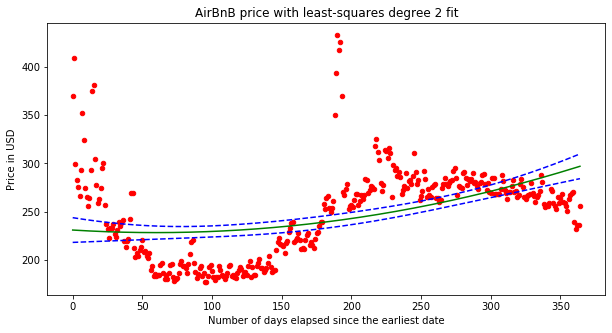

In [93]:
# degree 2 polynomial
#plt.rcParams["figure.figsize"] = [10,5]
#fig, ax2 = plt.subplots(1,1)

fit2_lm = sm.ols(formula="price ~ numerical_date3 + np.power(numerical_date3, 2)", data=calendar_train_available_daygroups).fit()
#fit2_lm1 = sm.ols(formula="price ~ np.vander(numerical_date2, 3, increasing=True) -1", data=calendar_train).fit()
poly_predictions = fit2_lm.get_prediction(pd.DataFrame(calendar_train_available_daygroups['numerical_date3'])).summary_frame()

ax2 = calendar_train_available_daygroups.plot.scatter(x='numerical_date3',y='price',c='Red',title="AirBnB price with least-squares degree 2 fit")
ax2.set_xlabel("Number of days elapsed since the earliest date")
ax2.set_ylabel("Price in USD")

ax2.plot(pd.DataFrame(calendar_train_available_daygroups['numerical_date3']), poly_predictions['mean'],color="green")
ax2.plot(pd.DataFrame(calendar_train_available_daygroups['numerical_date3']), poly_predictions['mean_ci_lower'], color="blue",linestyle="dashed")
ax2.plot(pd.DataFrame(calendar_train_available_daygroups['numerical_date3']), poly_predictions['mean_ci_upper'], color="blue",linestyle="dashed");

print('degree 2 polynomial r2 score in the training data:', r2_score(calendar_train_available_daygroups['price'], poly_predictions['mean']))
print('degree 2 polynomial r2 score in the testing data:', r2_score(calendar_test_available_daygroups['price'], poly_predictions['mean']))




degree 3 polynomial r2 score in the training data: 0.6380031312876848
degree 3 polynomial r2 score in the testing data: 0.6139438232999757


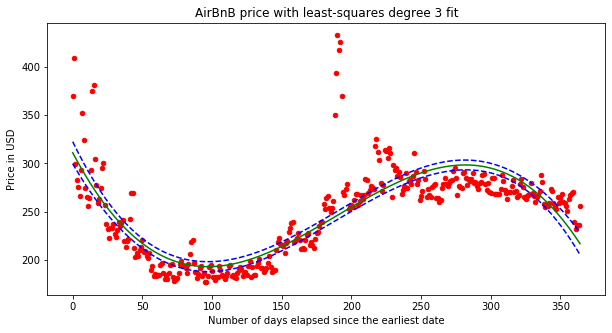

In [92]:
# degree 3 polynomial
#plt.rcParams["figure.figsize"] = [10,5]
#fig, ax2 = plt.subplots(1,1)

fit3_lm = sm.ols(formula="price ~ numerical_date3 + np.power(numerical_date3, 2) + np.power(numerical_date3, 3)", data=calendar_train_available_daygroups).fit()
#fit2_lm1 = sm.ols(formula="price ~ np.vander(numerical_date2, 3, increasing=True) -1", data=calendar_train).fit()
poly_predictions = fit3_lm.get_prediction(pd.DataFrame(calendar_train_available_daygroups['numerical_date3'])).summary_frame()

ax2 = calendar_train_available_daygroups.plot.scatter(x='numerical_date3',y='price',c='Red',title="AirBnB price with least-squares degree 3 fit")
ax2.set_xlabel("Number of days elapsed since the earliest date")
ax2.set_ylabel("Price in USD")

ax2.plot(pd.DataFrame(calendar_train_available_daygroups['numerical_date3']), poly_predictions['mean'],color="green")
ax2.plot(pd.DataFrame(calendar_train_available_daygroups['numerical_date3']), poly_predictions['mean_ci_lower'], color="blue",linestyle="dashed")
ax2.plot(pd.DataFrame(calendar_train_available_daygroups['numerical_date3']), poly_predictions['mean_ci_upper'], color="blue",linestyle="dashed");

print('degree 3 polynomial r2 score in the training data:', r2_score(calendar_train_available_daygroups['price'], poly_predictions['mean']))
print('degree 3 polynomial r2 score in the testing data:', r2_score(calendar_test_available_daygroups['price'], poly_predictions['mean']))




degree 5 polynomial r2 score in the training data: 0.7168986371398361
degree 5 polynomial r2 score in the testing data: 0.6850165200653858


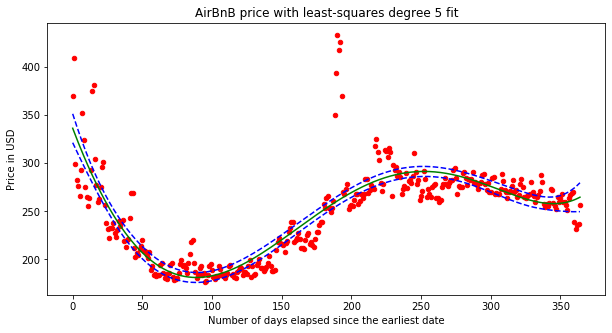

In [91]:
# degree 5 polynomial
#plt.rcParams["figure.figsize"] = [10,5]
#fig, ax2 = plt.subplots(1,1)

fit5_lm = sm.ols(formula="price ~ numerical_date3 + np.power(numerical_date3, 2) + np.power(numerical_date3, 3) + np.power(numerical_date3, 4) + np.power(numerical_date3, 5)", data=calendar_train_available_daygroups).fit()
#fit2_lm1 = sm.ols(formula="price ~ np.vander(numerical_date2, 3, increasing=True) -1", data=calendar_train).fit()
poly_predictions = fit5_lm.get_prediction(pd.DataFrame(calendar_train_available_daygroups['numerical_date3'])).summary_frame()

ax2 = calendar_train_available_daygroups.plot.scatter(x='numerical_date3',y='price',c='Red',title="AirBnB price with least-squares degree 5 fit")
ax2.set_xlabel("Number of days elapsed since the earliest date")
ax2.set_ylabel("Price in USD")

ax2.plot(pd.DataFrame(calendar_train_available_daygroups['numerical_date3']), poly_predictions['mean'],color="green")
ax2.plot(pd.DataFrame(calendar_train_available_daygroups['numerical_date3']), poly_predictions['mean_ci_lower'], color="blue",linestyle="dashed")
ax2.plot(pd.DataFrame(calendar_train_available_daygroups['numerical_date3']), poly_predictions['mean_ci_upper'], color="blue",linestyle="dashed");

print('degree 5 polynomial r2 score in the training data:', r2_score(calendar_train_available_daygroups['price'], poly_predictions['mean']))
print('degree 5 polynomial r2 score in the testing data:', r2_score(calendar_test_available_daygroups['price'], poly_predictions['mean']))



degree 8 polynomial r2 score in the training data: -3.973536531326528
degree 8 polynomial r2 score in the testing data: -3.6775242312221215


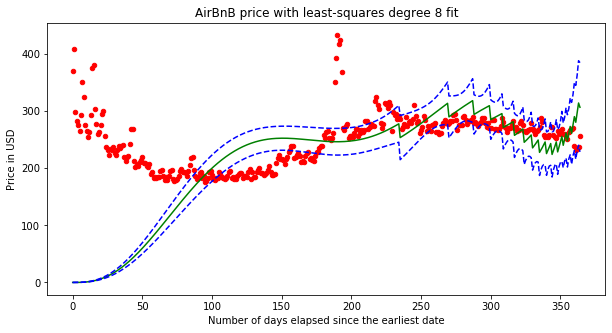

In [90]:
# degree 8 polynomial
#plt.rcParams["figure.figsize"] = [10,5]
#fig, ax2 = plt.subplots(1,1)

fit8_lm = sm.ols(formula="price ~ numerical_date3 + np.power(numerical_date3, 2) + np.power(numerical_date3, 3) + np.power(numerical_date3, 4) + np.power(numerical_date3, 5) + np.power(numerical_date3, 6) + np.power(numerical_date3, 7) + np.power(numerical_date3, 8)", data=calendar_train_available_daygroups).fit()
#fit2_lm1 = sm.ols(formula="price ~ np.vander(numerical_date2, 3, increasing=True) -1", data=calendar_train).fit()
poly_predictions = fit8_lm.get_prediction(pd.DataFrame(calendar_train_available_daygroups['numerical_date3'])).summary_frame()

ax2 = calendar_train_available_daygroups.plot.scatter(x='numerical_date3',y='price',c='Red',title="AirBnB price with least-squares degree 8 fit")
ax2.set_xlabel("Number of days elapsed since the earliest date")
ax2.set_ylabel("Price in USD")

ax2.plot(pd.DataFrame(calendar_train_available_daygroups['numerical_date3']), poly_predictions['mean'],color="green")
ax2.plot(pd.DataFrame(calendar_train_available_daygroups['numerical_date3']), poly_predictions['mean_ci_lower'], color="blue",linestyle="dashed")
ax2.plot(pd.DataFrame(calendar_train_available_daygroups['numerical_date3']), poly_predictions['mean_ci_upper'], color="blue",linestyle="dashed");

print('degree 8 polynomial r2 score in the training data:', r2_score(calendar_train_available_daygroups['price'], poly_predictions['mean']))
print('degree 8 polynomial r2 score in the testing data:', r2_score(calendar_test_available_daygroups['price'], poly_predictions['mean']))



In [98]:
calendar_train_available_daygroups.iloc[:,4]

numerical_date2
0        0
1        1
2        2
3        3
4        4
      ... 
360    360
361    361
362    362
363    363
364    364
Name: numerical_date3, Length: 365, dtype: int64

In [74]:
# thought it might be faster than lambda but it's not fast either
#calendar_train_numerical_date = []
#for i in range(len(calendar_train)):
#    calendar_train_numerical_date.append((calendar_train.iloc[i]['date']-calendar_train.iloc[-1]['date']).days)

KeyboardInterrupt: 

### 1. Polynomials

In [9]:
#your code here


_your answer here_


compare r2 in test sets here??

### 2. Degree 8 oddity
_your answer here_


negative and outside of 1 means model is way worse than data

Runge's phenomenon/ oscillation at limits.  
most unusual results are at the edges because few data points 
why we would want to use natural spline. enforces at the edges that its linear or flat

not just overfitting with high degree polynomial

### 3. Smoothing spline model with the smoothness parameter chosen by cross-validation on the training set.

train r2: 0.8677205645446704
test r2: 0.8306158483166473


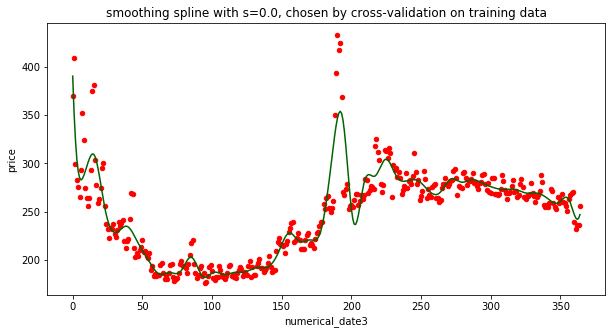

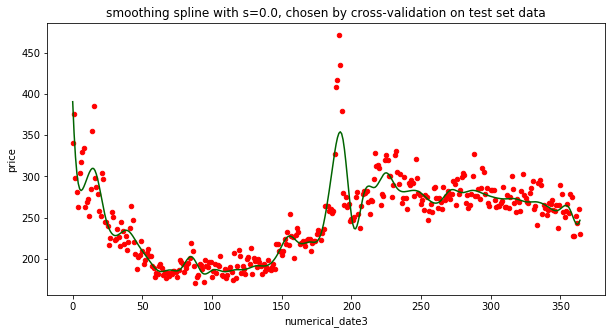

In [135]:
# choose smoothness parameters to check
candidate_smoothings = np.linspace(0,1000,10)
#candidate_smoothings = [0,1e-2,1e-3,1e-4,1e-5]
kf = KFold(n_splits=5, random_state=47, shuffle=True)
scores = np.zeros((5,len(candidate_smoothings)))

#should i be splitting the whole dataset or just the train set???

for i, (train_index, test_index) in enumerate(kf.split(calendar_train_available_daygroups)):
    train_df = calendar_train_available_daygroups.iloc[train_index,:]
    test_df = calendar_train_available_daygroups.iloc[test_index,:]
    for j,cur_smoothing in enumerate(candidate_smoothings):
        #cur_model = LinearGAM(s(4)).fit(X, y)
        cur_model = LinearGAM(lam=cur_smoothing, n_splines=50).fit(calendar_train_available_daygroups['numerical_date3'],calendar_train_available_daygroups['price'])
        #XX = cur_model.generate_X_grid(term=4)
        #plt.scatter(X,y,alpha=0.3);
        #plt.plot(XX, gam.predict(XX));
        
        scores[i,j] = r2_score(test_df['price'], cur_model.predict(test_df['numerical_date3']))
        
np.mean(scores, axis=0)

best_s = candidate_smoothings[np.argmax(np.mean(scores, axis=0))]
#plt.rcParams["figure.figsize"] = [10,5]
#fig, ax = plt.subplots(2,1)

ax[0] = calendar_train_available_daygroups.plot.scatter(x='numerical_date3',y='price',c='Red',title="smoothing spline with s={}, chosen by cross-validation on training data".format(best_s))
best_model = LinearGAM(lam=best_s, n_splines=50).fit(calendar_train_available_daygroups['numerical_date3'],calendar_train_available_daygroups['price'])
ax[0].plot(calendar_train_available_daygroups['numerical_date3'], best_model.predict(calendar_train_available_daygroups['numerical_date3']), color="darkgreen")

ax[1] = calendar_test_available_daygroups.plot.scatter(x='numerical_date3',y='price',c='Red',title="smoothing spline with s={}, chosen by cross-validation on test set data".format(best_s))

ax[1].plot(calendar_test_available_daygroups['numerical_date3'], best_model.predict(calendar_test_available_daygroups['numerical_date3']), color="darkgreen")

#plt.show()

print('train r2:', r2_score(calendar_train_available_daygroups['price'], best_model.predict(calendar_train_available_daygroups['numerical_date3'])))
print('test r2:', r2_score(calendar_test_available_daygroups['price'], best_model.predict(calendar_test_available_daygroups['numerical_date3'])))

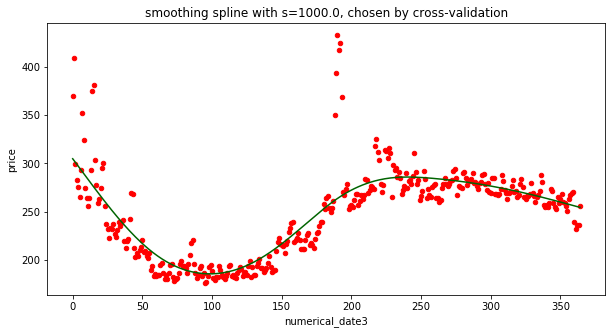

In [136]:
# show more smoothing 
best_s = candidate_smoothings[9]

ax = calendar_train_available_daygroups.plot.scatter(x='numerical_date3',y='price',c='Red',title="smoothing spline with s={}, chosen by cross-validation".format(best_s))
best_model = LinearGAM(lam=best_s, n_splines=50).fit(calendar_train_available_daygroups['numerical_date3'],calendar_train_available_daygroups['price'])
ax.plot(calendar_train_available_daygroups['numerical_date3'], best_model.predict(calendar_train_available_daygroups['numerical_date3']), color="darkgreen")
plt.show()

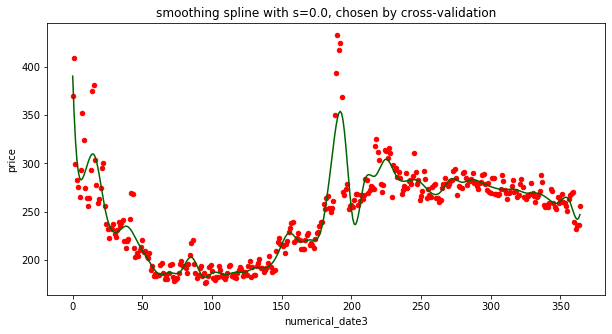

In [137]:
# HOW CAN I SHOW LESS SMOOTHIGN???
# show less smoothing 
best_s = candidate_smoothings[0]

ax = calendar_train_available_daygroups.plot.scatter(x='numerical_date3',y='price',c='Red',title="smoothing spline with s={}, chosen by cross-validation".format(best_s))
best_model = LinearGAM(lam=best_s, n_splines=50).fit(calendar_train_available_daygroups['numerical_date3'],calendar_train_available_daygroups['price'])
ax.plot(calendar_train_available_daygroups['numerical_date3'], best_model.predict(calendar_train_available_daygroups['numerical_date3']), color="darkgreen")
plt.show()

### 4. Effects of parameters
_your answer here_

### Part 1b: Adapting to weekends

It is possible/likely that prices on weekends (Friday nights and Saturday nights) are systematically higher than prices on weekdays, and that including this aspect of the data-generating process in our model will produce a better fit.

5. Create a binary indicator of weekend versus non-weekend, and include it in your best-performing model from above. How does it impact the model's performance?  
*Hint*: include a categorical variable in a GAM by importing and using `pygam.f` in the same way you've used `pygam.s` for continuous variables.


In [16]:
#your code here


### Part 1c: Going the Distance

You may have noticed from your scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices.

Sort the training data in decreasing order of average price, extracting the 10 most expensive dates. Why are the prices on these days so high? Is it something about the days themselves, noise, an artifact of data collection, or something else?

In [3]:
#your code here


_your answer here_

### Problem 2: Predicting Airbnb Rental Price Through Listing Features

In this problem, we'll continue our exploration of Airbnb data by predicting price based on listing features. The data can be found in `listings_train.csv` and `listings_test.csv`.

First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?

In [138]:
#your code here

listings_train = pd.read_csv('data/listings_train.csv')
listings_test = pd.read_csv('data/listings_test.csv')



In [146]:
listings_train.columns

Index(['host_total_listings_count', 'room_type', 'latitude', 'longitude',
       'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit',
       'cleaning_fee', 'availability_365', 'number_of_reviews'],
      dtype='object')

In [139]:
listings_train.head()

,host_total_listings_count,room_type,latitude,longitude,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,availability_365,number_of_reviews
0,1,Private room,42.347956,-71.155196,1.0,1,1,52,1,65,365,26
1,85,Entire home/apt,42.349299,-71.083470,1.0,0,1,110,1,104,107,38
2,6,Entire home/apt,42.341902,-71.073792,1.0,1,1,67,45,56,322,9
3,1,Entire home/apt,42.319235,-71.105016,2.0,2,2,103,8,113,341,49
4,1,Entire home/apt,42.346452,-71.134896,1.0,0,1,8,24,82,41,13


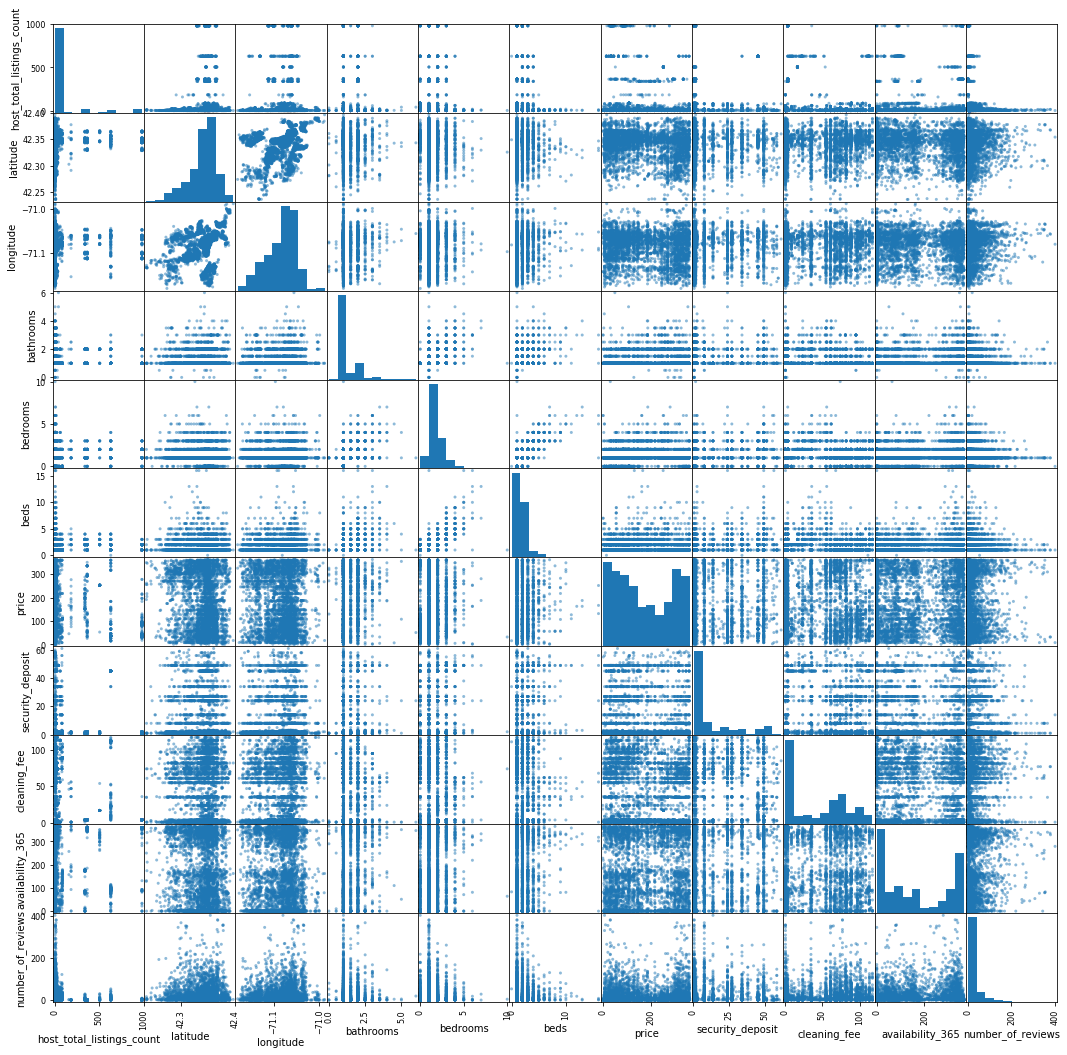

In [145]:
pd.plotting.scatter_matrix(listings_train,figsize=(18,18));

_your answer here_

### Part 2a: Polynomial Regression

Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
    
* Linear regression
* Regression with polynomial basis functions of degree 3 (i.e., basis functions $x$, $x^2$, $x^3$ for each predictor $x$) for quantitative predictors.

In [151]:
listings_train.columns

Index(['host_total_listings_count', 'room_type', 'latitude', 'longitude',
       'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit',
       'cleaning_fee', 'availability_365', 'number_of_reviews'],
      dtype='object')

In [153]:
#linear regression
# columns 


fit2_lm = sm.ols(formula="price ~ host_total_listings_count + room_type + latitude + longitude + bathrooms + bedrooms + beds + security_deposit + cleaning_fee + availability_365 + number_of_reviews",data=listings_train).fit()

poly_predictions = fit2_lm.get_prediction(listings_train.drop(columns=['price'],inplace=False)).summary_frame()


print('train r2:', r2_score(listings_train['price'], fit2_lm.predict(listings_train.drop(columns=['price'],inplace=False))))
print('test r2:', r2_score(listings_test['price'], fit2_lm.predict(listings_test.drop(columns=['price'],inplace=False))))



train r2: 0.24941504849625218
test r2: 0.18479127231125603


In [154]:
# polynomial basis functions of degree 3
# remove all room_type variables since not quantitative 

fit2_lm = sm.ols(formula="price ~ host_total_listings_count + host_total_listings_count**2 + host_total_listings_count**3 + latitude + latitude**2 + latitude**3 + longitude + longitude**2 + longitude**3 + bathrooms + bathrooms**2 + bathrooms**3 + bedrooms + bedrooms**2 + bedrooms**3 + beds + beds**2 + beds**3 + security_deposit + security_deposit**2 + security_deposit**3 + cleaning_fee + cleaning_fee**2 + cleaning_fee**3 + availability_365 + availability_365**2 + availability_365**3 + number_of_reviews + number_of_reviews**2 + number_of_reviews**3",data=listings_train).fit()

poly_predictions = fit2_lm.get_prediction(listings_train.drop(columns=['price'],inplace=False)).summary_frame()


print('train r2:', r2_score(listings_train['price'], fit2_lm.predict(listings_train.drop(columns=['price'],inplace=False))))
print('test r2:', r2_score(listings_test['price'], fit2_lm.predict(listings_test.drop(columns=['price'],inplace=False))))




train r2: 0.11182732477334756
test r2: 0.03996881056515322


### Part 2b: Generalized Additive Model (GAM)

1. Do you see any advantage in fitting an additive regression model to these data, compared to the above models?

1. Fit a GAM to the training set, and compare the test $R^2$ of the fitted model to the above models. You may use a smoothing spline basis function on each predictor, with the same smoothing parameter for each basis function, tuned using cross-validation on the training set.

2. Plot and examine the smooth of each predictor for the fitted GAM. What are some useful insights conveyed by these plots?


_your answer here_


additive regression models ARE THESE GAMS can capture more complex relations between predictors and response

more nonlinear relations captured??



In [31]:
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder
#your code here

f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10)


In [4]:
#your code here

### Part 2c: Putting it All Together
Using the GAM outputs and insights from part 1), discuss the most important variables in the driving prices, and give advide to a frugal traveller hoping to visit Boston.

_your answer here_